In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json, random, pickle, h5py
import pandas as pd
import numpy as np

/Users/pakpoom/anaconda3/envs/python27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [3]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [4]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [5]:
pick_frame_every_no = max_frame / 50 + 1

In [6]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.zeros([data_length])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[2 * ((word_no * data_per_word) + data_no), curr_idx, :] = feature
            curr_idx += 1

        y[2 * ((word_no * data_per_word) + data_no)] = word_no
#         print((word_no * data_per_word * 2) + data_no)
        del_idx = range(0, len(json_data), pick_frame_every_no)
        json_data_speedup = np.delete(json_data, del_idx)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data_speedup):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[(word_no * data_per_word * 2) + data_per_word + data_no, curr_idx, :] = feature
            curr_idx += 1

        y[(word_no * data_per_word * 2) + data_per_word + data_no] = word_no
#         print((word_no * data_per_word * 2) + 1 + data_no)
#         print('___')

In [7]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [8]:
x_train = np.zeros([data_length * 4 / 6, timesteps, dimensions])
y_train = np.zeros([data_length * 4 / 6])
x_test = np.zeros([data_length / 6, timesteps, dimensions])
y_test = np.zeros([data_length / 6])
x_valid = np.zeros([data_length / 6, timesteps, dimensions])
y_valid = np.zeros([data_length / 6])
train_count = test_count = valid_count = 0

for idx in range(data_length):
    if idx % 6 == 0:
        test_idx = random.sample(xrange(6), 1)
        valid_idx = random.sample(xrange(6), 1)
        while valid_idx == test_idx:
            valid_idx = random.sample(xrange(6), 1)
#         print('rand', test_idx, valid_idx)
    if idx % 6 == test_idx[0]:
#         print('test', test_count, idx)
        x_test[test_count] = x_norm[idx]
        y_test[test_count] = y[idx]
        test_count += 1
    elif idx % 6 == valid_idx[0]:
#         print('valid', valid_count, idx)
        x_valid[valid_count] = x_norm[idx]
        y_valid[valid_count] = y[idx]
        valid_count += 1
    else:
#         print('train', train_count, idx)
        x_train[train_count] = x_norm[idx]
        y_train[train_count] = y[idx]
        train_count += 1

In [9]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 4 / 6, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 4 / 6])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [10]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))
Y_valid = np_utils.to_categorical(y_valid, len(words))

In [11]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_valid, Y_valid), epochs=2000, batch_size=8, shuffle=True)
# model.save_weights("model_weight.h5")
model.save("./history/model213182331.h5")
with open('./history/history213182331.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 684 samples, validate on 171 samples
Epoch 1/2000
684/684 [==============================] - 6s 8ms/step - loss: 2.8169 - acc: 0.2544 - val_loss: 2.6899 - val_acc: 0.2865
Epoch 2/2000
684/684 [==============================] - 4s 5ms/step - loss: 2.7129 - acc: 0.2632 - val_loss: 2.3032 - val_acc: 0.2865
Epoch 3/2000
684/684 [==============================] - 4s 5ms/step - loss: 2.4209 - acc: 0.2558 - val_loss: 2.2567 - val_acc: 0.2690
Epoch 4/2000
684/684 [==============================] - 4s 5ms/step - loss: 2.3420 - acc: 0.2588 - val_loss: 2.2349 - val_acc: 0.2865
Epoch 5/2000
684/684 [==============================] - 4s 5ms/step - loss: 2.3301 - acc: 0.2749 - val_loss: 2.2353 - val_acc: 0.2865
Epoch 6/2000
684/684 [==============================] - 4s 6ms/step - loss: 2.3162 - acc: 0.2719 - val_loss: 2.2239 - val_acc: 0.3041
Epoch 7/2000
684/684 [==============================] - 4s 6ms/step - loss: 2.2595 - acc: 0.2851 - val_loss: 2.2058 - val_acc: 0.3275
Epoch 8/2000
684

684/684 [==============================] - 4s 5ms/step - loss: 1.6240 - acc: 0.4050 - val_loss: 1.3349 - val_acc: 0.5263
Epoch 62/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.6370 - acc: 0.3889 - val_loss: 1.3378 - val_acc: 0.5088
Epoch 63/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.6231 - acc: 0.4181 - val_loss: 1.3647 - val_acc: 0.4737
Epoch 64/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.6077 - acc: 0.4079 - val_loss: 1.3434 - val_acc: 0.4912
Epoch 65/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.6452 - acc: 0.4006 - val_loss: 1.3978 - val_acc: 0.4561
Epoch 66/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.6083 - acc: 0.4371 - val_loss: 1.3588 - val_acc: 0.5029
Epoch 67/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.6044 - acc: 0.4167 - val_loss: 1.3318 - val_acc: 0.5088
Epoch 68/2000
684/684 [==============================] - 4s 5ms/step 

684/684 [==============================] - 4s 5ms/step - loss: 1.3974 - acc: 0.4678 - val_loss: 1.1279 - val_acc: 0.5848
Epoch 122/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.4474 - acc: 0.4635 - val_loss: 1.1522 - val_acc: 0.5263
Epoch 123/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.3789 - acc: 0.4664 - val_loss: 1.1411 - val_acc: 0.5673
Epoch 124/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.4302 - acc: 0.4825 - val_loss: 1.1447 - val_acc: 0.5146
Epoch 125/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.4113 - acc: 0.4722 - val_loss: 1.1471 - val_acc: 0.5205
Epoch 126/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.4089 - acc: 0.5205 - val_loss: 1.1049 - val_acc: 0.5556
Epoch 127/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.4580 - acc: 0.4766 - val_loss: 1.1195 - val_acc: 0.5497
Epoch 128/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 5ms/step - loss: 1.2582 - acc: 0.5380 - val_loss: 1.0306 - val_acc: 0.5906
Epoch 182/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.2492 - acc: 0.5365 - val_loss: 1.0159 - val_acc: 0.6199
Epoch 183/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.2216 - acc: 0.5439 - val_loss: 0.9928 - val_acc: 0.6316
Epoch 184/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.2020 - acc: 0.5453 - val_loss: 0.9910 - val_acc: 0.6316
Epoch 185/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.2262 - acc: 0.5541 - val_loss: 0.9640 - val_acc: 0.6140
Epoch 186/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.2646 - acc: 0.5088 - val_loss: 0.9874 - val_acc: 0.6608
Epoch 187/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.2260 - acc: 0.5351 - val_loss: 0.9592 - val_acc: 0.6433
Epoch 188/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 5ms/step - loss: 1.1746 - acc: 0.5760 - val_loss: 0.8749 - val_acc: 0.7018
Epoch 242/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.0645 - acc: 0.6053 - val_loss: 0.9025 - val_acc: 0.6842
Epoch 243/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.1177 - acc: 0.5950 - val_loss: 0.8875 - val_acc: 0.7018
Epoch 244/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.0767 - acc: 0.6096 - val_loss: 0.8764 - val_acc: 0.7135
Epoch 245/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.1269 - acc: 0.5950 - val_loss: 0.8913 - val_acc: 0.6491
Epoch 246/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.1446 - acc: 0.5906 - val_loss: 0.8555 - val_acc: 0.6667
Epoch 247/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.1093 - acc: 0.5950 - val_loss: 0.8783 - val_acc: 0.6784
Epoch 248/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 5ms/step - loss: 1.0609 - acc: 0.6243 - val_loss: 0.7404 - val_acc: 0.7076
Epoch 302/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.0790 - acc: 0.6389 - val_loss: 0.7354 - val_acc: 0.7310
Epoch 303/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.0297 - acc: 0.6301 - val_loss: 0.7286 - val_acc: 0.7310
Epoch 304/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.0170 - acc: 0.6345 - val_loss: 0.7620 - val_acc: 0.7251
Epoch 305/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.0269 - acc: 0.6447 - val_loss: 0.7222 - val_acc: 0.7719
Epoch 306/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.9922 - acc: 0.6418 - val_loss: 0.7288 - val_acc: 0.7485
Epoch 307/2000
684/684 [==============================] - 4s 5ms/step - loss: 1.0039 - acc: 0.6374 - val_loss: 0.7453 - val_acc: 0.7018
Epoch 308/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 5ms/step - loss: 0.9765 - acc: 0.6550 - val_loss: 0.6895 - val_acc: 0.7251
Epoch 362/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.9501 - acc: 0.6623 - val_loss: 0.6960 - val_acc: 0.7544
Epoch 363/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.9752 - acc: 0.6462 - val_loss: 0.6700 - val_acc: 0.7427
Epoch 364/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.9753 - acc: 0.6433 - val_loss: 0.6954 - val_acc: 0.7135
Epoch 365/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.9972 - acc: 0.6550 - val_loss: 0.7154 - val_acc: 0.7018
Epoch 366/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.9535 - acc: 0.6784 - val_loss: 0.7393 - val_acc: 0.7251
Epoch 367/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.9641 - acc: 0.6477 - val_loss: 0.7264 - val_acc: 0.7251
Epoch 368/2000
684/684 [==============================] - 4s 6m

684/684 [==============================] - 4s 6ms/step - loss: 0.8923 - acc: 0.6623 - val_loss: 0.6098 - val_acc: 0.7778
Epoch 422/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8215 - acc: 0.7032 - val_loss: 0.6115 - val_acc: 0.7836
Epoch 423/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8829 - acc: 0.6827 - val_loss: 0.6411 - val_acc: 0.7895
Epoch 424/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8484 - acc: 0.7149 - val_loss: 0.6378 - val_acc: 0.7836
Epoch 425/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.9263 - acc: 0.6974 - val_loss: 0.6570 - val_acc: 0.7719
Epoch 426/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8671 - acc: 0.7018 - val_loss: 0.6683 - val_acc: 0.7368
Epoch 427/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8905 - acc: 0.7061 - val_loss: 0.6568 - val_acc: 0.7602
Epoch 428/2000
684/684 [==============================] - 4s 6m

684/684 [==============================] - 4s 5ms/step - loss: 0.8124 - acc: 0.7120 - val_loss: 0.6308 - val_acc: 0.7485
Epoch 482/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8702 - acc: 0.7120 - val_loss: 0.6192 - val_acc: 0.7602
Epoch 483/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8127 - acc: 0.7149 - val_loss: 0.6101 - val_acc: 0.7485
Epoch 484/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8468 - acc: 0.6930 - val_loss: 0.6124 - val_acc: 0.7485
Epoch 485/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8028 - acc: 0.7105 - val_loss: 0.6275 - val_acc: 0.7485
Epoch 486/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8057 - acc: 0.7222 - val_loss: 0.6328 - val_acc: 0.7368
Epoch 487/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8747 - acc: 0.6871 - val_loss: 0.6359 - val_acc: 0.7427
Epoch 488/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 5ms/step - loss: 0.7483 - acc: 0.7398 - val_loss: 0.5926 - val_acc: 0.7895
Epoch 542/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7790 - acc: 0.7164 - val_loss: 0.5752 - val_acc: 0.7602
Epoch 543/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8365 - acc: 0.6959 - val_loss: 0.5927 - val_acc: 0.7778
Epoch 544/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7930 - acc: 0.7295 - val_loss: 0.5976 - val_acc: 0.7953
Epoch 545/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7938 - acc: 0.7456 - val_loss: 0.6309 - val_acc: 0.7544
Epoch 546/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8130 - acc: 0.7354 - val_loss: 0.5986 - val_acc: 0.7719
Epoch 547/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7675 - acc: 0.7383 - val_loss: 0.6045 - val_acc: 0.7485
Epoch 548/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 5ms/step - loss: 0.8076 - acc: 0.7500 - val_loss: 0.6109 - val_acc: 0.7544
Epoch 602/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7947 - acc: 0.7354 - val_loss: 0.6187 - val_acc: 0.7427
Epoch 603/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7496 - acc: 0.7471 - val_loss: 0.6090 - val_acc: 0.7485
Epoch 604/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7539 - acc: 0.7383 - val_loss: 0.6172 - val_acc: 0.7544
Epoch 605/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.8046 - acc: 0.7442 - val_loss: 0.5951 - val_acc: 0.7719
Epoch 606/2000
684/684 [==============================] - 3s 5ms/step - loss: 0.7255 - acc: 0.7485 - val_loss: 0.5832 - val_acc: 0.7895
Epoch 607/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7269 - acc: 0.7427 - val_loss: 0.5803 - val_acc: 0.7602
Epoch 608/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 6ms/step - loss: 0.7156 - acc: 0.7558 - val_loss: 0.5942 - val_acc: 0.7544
Epoch 662/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7384 - acc: 0.7354 - val_loss: 0.5924 - val_acc: 0.7485
Epoch 663/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7036 - acc: 0.7573 - val_loss: 0.5979 - val_acc: 0.7544
Epoch 664/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7154 - acc: 0.7529 - val_loss: 0.5976 - val_acc: 0.7544
Epoch 665/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6970 - acc: 0.7617 - val_loss: 0.6029 - val_acc: 0.7544
Epoch 666/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.7888 - acc: 0.7325 - val_loss: 0.6126 - val_acc: 0.7602
Epoch 667/2000
684/684 [==============================] - 5s 8ms/step - loss: 0.7669 - acc: 0.7500 - val_loss: 0.5922 - val_acc: 0.7778
Epoch 668/2000
684/684 [==============================] - 7s 10

684/684 [==============================] - 4s 6ms/step - loss: 0.7231 - acc: 0.7515 - val_loss: 0.5435 - val_acc: 0.8012
Epoch 722/2000
684/684 [==============================] - 6s 8ms/step - loss: 0.7235 - acc: 0.7719 - val_loss: 0.5368 - val_acc: 0.8012
Epoch 723/2000
684/684 [==============================] - 6s 9ms/step - loss: 0.6894 - acc: 0.7734 - val_loss: 0.5401 - val_acc: 0.7953
Epoch 724/2000
684/684 [==============================] - 6s 9ms/step - loss: 0.6937 - acc: 0.7632 - val_loss: 0.5343 - val_acc: 0.7895
Epoch 725/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6764 - acc: 0.7705 - val_loss: 0.5332 - val_acc: 0.7953
Epoch 726/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7644 - acc: 0.7500 - val_loss: 0.5338 - val_acc: 0.7895
Epoch 727/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6892 - acc: 0.7719 - val_loss: 0.5323 - val_acc: 0.7953
Epoch 728/2000
684/684 [==============================] - 5s 7m

684/684 [==============================] - 4s 6ms/step - loss: 0.7136 - acc: 0.7822 - val_loss: 0.5511 - val_acc: 0.7661
Epoch 782/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6567 - acc: 0.7807 - val_loss: 0.5359 - val_acc: 0.7836
Epoch 783/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6775 - acc: 0.7544 - val_loss: 0.5487 - val_acc: 0.7719
Epoch 784/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6675 - acc: 0.7865 - val_loss: 0.5403 - val_acc: 0.7836
Epoch 785/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.7521 - acc: 0.7558 - val_loss: 0.5307 - val_acc: 0.7953
Epoch 786/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7083 - acc: 0.7602 - val_loss: 0.5502 - val_acc: 0.7778
Epoch 787/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6511 - acc: 0.7749 - val_loss: 0.5586 - val_acc: 0.7778
Epoch 788/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 6ms/step - loss: 0.7088 - acc: 0.7690 - val_loss: 0.5228 - val_acc: 0.8070
Epoch 842/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.7301 - acc: 0.7690 - val_loss: 0.5040 - val_acc: 0.8187
Epoch 843/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.7070 - acc: 0.7705 - val_loss: 0.5137 - val_acc: 0.8129
Epoch 844/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7116 - acc: 0.7675 - val_loss: 0.5141 - val_acc: 0.8070
Epoch 845/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6897 - acc: 0.7763 - val_loss: 0.5319 - val_acc: 0.8070
Epoch 846/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7151 - acc: 0.7705 - val_loss: 0.5097 - val_acc: 0.8246
Epoch 847/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.7009 - acc: 0.7822 - val_loss: 0.5064 - val_acc: 0.8070
Epoch 848/2000
684/684 [==============================] - 4s 6m

684/684 [==============================] - 4s 6ms/step - loss: 0.6819 - acc: 0.7719 - val_loss: 0.5078 - val_acc: 0.7953
Epoch 902/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6264 - acc: 0.8012 - val_loss: 0.5049 - val_acc: 0.8070
Epoch 903/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6653 - acc: 0.7909 - val_loss: 0.5122 - val_acc: 0.7953
Epoch 904/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6660 - acc: 0.7851 - val_loss: 0.5141 - val_acc: 0.8012
Epoch 905/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.7690 - acc: 0.7690 - val_loss: 0.5157 - val_acc: 0.8070
Epoch 906/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6735 - acc: 0.7778 - val_loss: 0.5291 - val_acc: 0.7953
Epoch 907/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.7435 - acc: 0.7573 - val_loss: 0.5297 - val_acc: 0.7895
Epoch 908/2000
684/684 [==============================] - 4s 7m

684/684 [==============================] - 5s 7ms/step - loss: 0.6962 - acc: 0.7690 - val_loss: 0.5222 - val_acc: 0.7836
Epoch 962/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6323 - acc: 0.7880 - val_loss: 0.5164 - val_acc: 0.7836
Epoch 963/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6018 - acc: 0.8012 - val_loss: 0.5212 - val_acc: 0.7895
Epoch 964/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6583 - acc: 0.7719 - val_loss: 0.5243 - val_acc: 0.8012
Epoch 965/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.6348 - acc: 0.7749 - val_loss: 0.5227 - val_acc: 0.7953
Epoch 966/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6882 - acc: 0.7705 - val_loss: 0.5184 - val_acc: 0.8012
Epoch 967/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6568 - acc: 0.7778 - val_loss: 0.5206 - val_acc: 0.7953
Epoch 968/2000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 5ms/step - loss: 0.6271 - acc: 0.8099 - val_loss: 0.4958 - val_acc: 0.8304
Epoch 1022/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6146 - acc: 0.8026 - val_loss: 0.5062 - val_acc: 0.8363
Epoch 1023/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6284 - acc: 0.7851 - val_loss: 0.4924 - val_acc: 0.8538
Epoch 1024/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6594 - acc: 0.7763 - val_loss: 0.4922 - val_acc: 0.8304
Epoch 1025/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6074 - acc: 0.8143 - val_loss: 0.4925 - val_acc: 0.8246
Epoch 1026/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6527 - acc: 0.7909 - val_loss: 0.4985 - val_acc: 0.8187
Epoch 1027/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6331 - acc: 0.7749 - val_loss: 0.5165 - val_acc: 0.8012
Epoch 1028/2000
684/684 [==============================] 

Epoch 1081/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6386 - acc: 0.7895 - val_loss: 0.4871 - val_acc: 0.8421
Epoch 1082/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6354 - acc: 0.8041 - val_loss: 0.4981 - val_acc: 0.8246
Epoch 1083/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6584 - acc: 0.7792 - val_loss: 0.4971 - val_acc: 0.8246
Epoch 1084/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6558 - acc: 0.7719 - val_loss: 0.4845 - val_acc: 0.8129
Epoch 1085/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6811 - acc: 0.7851 - val_loss: 0.4932 - val_acc: 0.8187
Epoch 1086/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6302 - acc: 0.7763 - val_loss: 0.4902 - val_acc: 0.8304
Epoch 1087/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6989 - acc: 0.7822 - val_loss: 0.4989 - val_acc: 0.8070
Epoch 1088/2000
684/684 [================

Epoch 1141/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5654 - acc: 0.8173 - val_loss: 0.4860 - val_acc: 0.8363
Epoch 1142/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5707 - acc: 0.8012 - val_loss: 0.4843 - val_acc: 0.8246
Epoch 1143/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5909 - acc: 0.8026 - val_loss: 0.4832 - val_acc: 0.8246
Epoch 1144/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6199 - acc: 0.8056 - val_loss: 0.4819 - val_acc: 0.8363
Epoch 1145/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6245 - acc: 0.8026 - val_loss: 0.4844 - val_acc: 0.8246
Epoch 1146/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5722 - acc: 0.8304 - val_loss: 0.4816 - val_acc: 0.8129
Epoch 1147/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6016 - acc: 0.8070 - val_loss: 0.4789 - val_acc: 0.8187
Epoch 1148/2000
684/684 [================

Epoch 1201/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5926 - acc: 0.8070 - val_loss: 0.5005 - val_acc: 0.8246
Epoch 1202/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5816 - acc: 0.7997 - val_loss: 0.4874 - val_acc: 0.8304
Epoch 1203/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5914 - acc: 0.8026 - val_loss: 0.4969 - val_acc: 0.8187
Epoch 1204/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5688 - acc: 0.8173 - val_loss: 0.4940 - val_acc: 0.8187
Epoch 1205/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6267 - acc: 0.7807 - val_loss: 0.4906 - val_acc: 0.8304
Epoch 1206/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6128 - acc: 0.7953 - val_loss: 0.4926 - val_acc: 0.8246
Epoch 1207/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5669 - acc: 0.8158 - val_loss: 0.4941 - val_acc: 0.8363
Epoch 1208/2000
684/684 [================

Epoch 1261/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6132 - acc: 0.8202 - val_loss: 0.4924 - val_acc: 0.8304
Epoch 1262/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5880 - acc: 0.8026 - val_loss: 0.5060 - val_acc: 0.8129
Epoch 1263/2000
684/684 [==============================] - 4s 7ms/step - loss: 0.5569 - acc: 0.8304 - val_loss: 0.4930 - val_acc: 0.8187
Epoch 1264/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6403 - acc: 0.7953 - val_loss: 0.4939 - val_acc: 0.8246
Epoch 1265/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5611 - acc: 0.8085 - val_loss: 0.4858 - val_acc: 0.8421
Epoch 1266/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5567 - acc: 0.8158 - val_loss: 0.4778 - val_acc: 0.8421
Epoch 1267/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6220 - acc: 0.7822 - val_loss: 0.4871 - val_acc: 0.8304
Epoch 1268/2000
684/684 [================

Epoch 1321/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6482 - acc: 0.8143 - val_loss: 0.4872 - val_acc: 0.8187
Epoch 1322/2000
684/684 [==============================] - 5s 8ms/step - loss: 0.5713 - acc: 0.8070 - val_loss: 0.4745 - val_acc: 0.8304
Epoch 1323/2000
684/684 [==============================] - 6s 9ms/step - loss: 0.5294 - acc: 0.8246 - val_loss: 0.4796 - val_acc: 0.8304
Epoch 1324/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5784 - acc: 0.8114 - val_loss: 0.4700 - val_acc: 0.8421
Epoch 1325/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6032 - acc: 0.7880 - val_loss: 0.4739 - val_acc: 0.8421
Epoch 1326/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5951 - acc: 0.8041 - val_loss: 0.4826 - val_acc: 0.8304
Epoch 1327/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.6009 - acc: 0.8129 - val_loss: 0.4807 - val_acc: 0.8129
Epoch 1328/2000
684/684 [================

Epoch 1381/2000
684/684 [==============================] - 6s 9ms/step - loss: 0.5683 - acc: 0.7968 - val_loss: 0.4669 - val_acc: 0.8421
Epoch 1382/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.6170 - acc: 0.7982 - val_loss: 0.4696 - val_acc: 0.8421
Epoch 1383/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6068 - acc: 0.8041 - val_loss: 0.4746 - val_acc: 0.8363
Epoch 1384/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5342 - acc: 0.8392 - val_loss: 0.4775 - val_acc: 0.8304
Epoch 1385/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5650 - acc: 0.7968 - val_loss: 0.4805 - val_acc: 0.8304
Epoch 1386/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5252 - acc: 0.8129 - val_loss: 0.4789 - val_acc: 0.8363
Epoch 1387/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5834 - acc: 0.8085 - val_loss: 0.4817 - val_acc: 0.8363
Epoch 1388/2000
684/684 [================

Epoch 1441/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5690 - acc: 0.8026 - val_loss: 0.4771 - val_acc: 0.8246
Epoch 1442/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5373 - acc: 0.8173 - val_loss: 0.4734 - val_acc: 0.8304
Epoch 1443/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6289 - acc: 0.8231 - val_loss: 0.4842 - val_acc: 0.8129
Epoch 1444/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.6016 - acc: 0.8173 - val_loss: 0.4684 - val_acc: 0.8363
Epoch 1445/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5274 - acc: 0.8304 - val_loss: 0.4715 - val_acc: 0.8304
Epoch 1446/2000
684/684 [==============================] - 4s 7ms/step - loss: 0.5503 - acc: 0.8099 - val_loss: 0.4657 - val_acc: 0.8363
Epoch 1447/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6041 - acc: 0.8187 - val_loss: 0.4644 - val_acc: 0.8304
Epoch 1448/2000
684/684 [================

Epoch 1501/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5746 - acc: 0.8143 - val_loss: 0.4853 - val_acc: 0.8187
Epoch 1502/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5891 - acc: 0.8319 - val_loss: 0.4832 - val_acc: 0.8304
Epoch 1503/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.6007 - acc: 0.8026 - val_loss: 0.4851 - val_acc: 0.8246
Epoch 1504/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5464 - acc: 0.8216 - val_loss: 0.4692 - val_acc: 0.8421
Epoch 1505/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5792 - acc: 0.8085 - val_loss: 0.4749 - val_acc: 0.8304
Epoch 1506/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5971 - acc: 0.7924 - val_loss: 0.4706 - val_acc: 0.8363
Epoch 1507/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5516 - acc: 0.8246 - val_loss: 0.4769 - val_acc: 0.8187
Epoch 1508/2000
684/684 [================

Epoch 1561/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5634 - acc: 0.8202 - val_loss: 0.4624 - val_acc: 0.8363
Epoch 1562/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5342 - acc: 0.8406 - val_loss: 0.4588 - val_acc: 0.8421
Epoch 1563/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5695 - acc: 0.8129 - val_loss: 0.4619 - val_acc: 0.8421
Epoch 1564/2000
684/684 [==============================] - 4s 7ms/step - loss: 0.5568 - acc: 0.8260 - val_loss: 0.4646 - val_acc: 0.8421
Epoch 1565/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5381 - acc: 0.8260 - val_loss: 0.4636 - val_acc: 0.8421
Epoch 1566/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5889 - acc: 0.8173 - val_loss: 0.4757 - val_acc: 0.8363
Epoch 1567/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5328 - acc: 0.8363 - val_loss: 0.4717 - val_acc: 0.8363
Epoch 1568/2000
684/684 [================

Epoch 1621/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5134 - acc: 0.8450 - val_loss: 0.4628 - val_acc: 0.8421
Epoch 1622/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5766 - acc: 0.8275 - val_loss: 0.4605 - val_acc: 0.8480
Epoch 1623/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5307 - acc: 0.8304 - val_loss: 0.4605 - val_acc: 0.8480
Epoch 1624/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5559 - acc: 0.8260 - val_loss: 0.4548 - val_acc: 0.8538
Epoch 1625/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5500 - acc: 0.8363 - val_loss: 0.4554 - val_acc: 0.8538
Epoch 1626/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6037 - acc: 0.8012 - val_loss: 0.4512 - val_acc: 0.8538
Epoch 1627/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5452 - acc: 0.8289 - val_loss: 0.4645 - val_acc: 0.8421
Epoch 1628/2000
684/684 [================

Epoch 1681/2000
684/684 [==============================] - 4s 7ms/step - loss: 0.5101 - acc: 0.8567 - val_loss: 0.4505 - val_acc: 0.8421
Epoch 1682/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5113 - acc: 0.8392 - val_loss: 0.4449 - val_acc: 0.8480
Epoch 1683/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5076 - acc: 0.8377 - val_loss: 0.4488 - val_acc: 0.8421
Epoch 1684/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5059 - acc: 0.8480 - val_loss: 0.4475 - val_acc: 0.8480
Epoch 1685/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5681 - acc: 0.8187 - val_loss: 0.4479 - val_acc: 0.8480
Epoch 1686/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5138 - acc: 0.8260 - val_loss: 0.4673 - val_acc: 0.8363
Epoch 1687/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5877 - acc: 0.8202 - val_loss: 0.4681 - val_acc: 0.8304
Epoch 1688/2000
684/684 [================

Epoch 1741/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.6103 - acc: 0.8187 - val_loss: 0.4635 - val_acc: 0.8421
Epoch 1742/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5365 - acc: 0.8436 - val_loss: 0.4529 - val_acc: 0.8480
Epoch 1743/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5627 - acc: 0.8187 - val_loss: 0.4525 - val_acc: 0.8421
Epoch 1744/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5590 - acc: 0.8260 - val_loss: 0.4583 - val_acc: 0.8421
Epoch 1745/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5265 - acc: 0.8275 - val_loss: 0.4559 - val_acc: 0.8363
Epoch 1746/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5288 - acc: 0.8129 - val_loss: 0.4486 - val_acc: 0.8480
Epoch 1747/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5700 - acc: 0.8173 - val_loss: 0.4493 - val_acc: 0.8480
Epoch 1748/2000
684/684 [================

Epoch 1801/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.4790 - acc: 0.8596 - val_loss: 0.4661 - val_acc: 0.8304
Epoch 1802/2000
684/684 [==============================] - 6s 9ms/step - loss: 0.5592 - acc: 0.8173 - val_loss: 0.4808 - val_acc: 0.8304
Epoch 1803/2000
684/684 [==============================] - 7s 10ms/step - loss: 0.5561 - acc: 0.8275 - val_loss: 0.4751 - val_acc: 0.8363
Epoch 1804/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5172 - acc: 0.8436 - val_loss: 0.4731 - val_acc: 0.8363
Epoch 1805/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5284 - acc: 0.8216 - val_loss: 0.4718 - val_acc: 0.8421
Epoch 1806/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5787 - acc: 0.8275 - val_loss: 0.4770 - val_acc: 0.8304
Epoch 1807/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5589 - acc: 0.8187 - val_loss: 0.4761 - val_acc: 0.8304
Epoch 1808/2000
684/684 [===============

Epoch 1861/2000
684/684 [==============================] - 4s 7ms/step - loss: 0.5791 - acc: 0.8158 - val_loss: 0.4588 - val_acc: 0.8421
Epoch 1862/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.4938 - acc: 0.8421 - val_loss: 0.4620 - val_acc: 0.8421
Epoch 1863/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5027 - acc: 0.8509 - val_loss: 0.4605 - val_acc: 0.8421
Epoch 1864/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5335 - acc: 0.8231 - val_loss: 0.4683 - val_acc: 0.8363
Epoch 1865/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5774 - acc: 0.8143 - val_loss: 0.4770 - val_acc: 0.8363
Epoch 1866/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5336 - acc: 0.8333 - val_loss: 0.4747 - val_acc: 0.8363
Epoch 1867/2000
684/684 [==============================] - 4s 7ms/step - loss: 0.5433 - acc: 0.8406 - val_loss: 0.4740 - val_acc: 0.8363
Epoch 1868/2000
684/684 [================

Epoch 1921/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5177 - acc: 0.8216 - val_loss: 0.4634 - val_acc: 0.8538
Epoch 1922/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.4500 - acc: 0.8567 - val_loss: 0.4658 - val_acc: 0.8480
Epoch 1923/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5485 - acc: 0.8363 - val_loss: 0.4565 - val_acc: 0.8538
Epoch 1924/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.4702 - acc: 0.8450 - val_loss: 0.4525 - val_acc: 0.8596
Epoch 1925/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.4961 - acc: 0.8158 - val_loss: 0.4616 - val_acc: 0.8480
Epoch 1926/2000
684/684 [==============================] - 4s 6ms/step - loss: 0.5192 - acc: 0.8319 - val_loss: 0.4768 - val_acc: 0.8363
Epoch 1927/2000
684/684 [==============================] - 4s 5ms/step - loss: 0.5033 - acc: 0.8363 - val_loss: 0.4719 - val_acc: 0.8421
Epoch 1928/2000
684/684 [================

Epoch 1981/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.4780 - acc: 0.8611 - val_loss: 0.4692 - val_acc: 0.8363
Epoch 1982/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5128 - acc: 0.8333 - val_loss: 0.4652 - val_acc: 0.8363
Epoch 1983/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.4540 - acc: 0.8596 - val_loss: 0.4614 - val_acc: 0.8421
Epoch 1984/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.4933 - acc: 0.8494 - val_loss: 0.4652 - val_acc: 0.8421
Epoch 1985/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.5511 - acc: 0.8099 - val_loss: 0.4651 - val_acc: 0.8421
Epoch 1986/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.4946 - acc: 0.8684 - val_loss: 0.4721 - val_acc: 0.8480
Epoch 1987/2000
684/684 [==============================] - 5s 7ms/step - loss: 0.4744 - acc: 0.8406 - val_loss: 0.4666 - val_acc: 0.8480
Epoch 1988/2000
684/684 [================

TypeError: can't pickle module objects

In [24]:
model = load_model("./history/model213182331.h5")
with open('./history/history213182331.pkl', 'rb') as handle:
    load_history = pickle.load(handle)

In [13]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 645us/step
('Test score:', 0.43841621549854504)
('Test accuracy:', 0.8596491245498434)


In [14]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


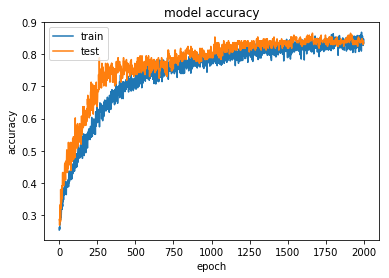

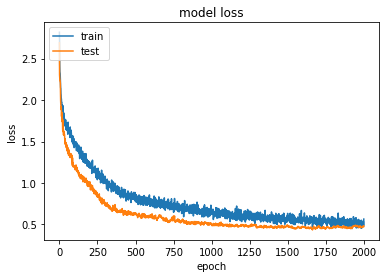

In [15]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()